In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import re
from nltk.corpus import wordnet as wn
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
# !pip install smote-variants

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# !pip install vecstack
from vecstack import StackingTransformer
# !pip install lightgbm
from lightgbm import LGBMClassifier
from mlxtend.plotting import plot_confusion_matrix
import pickle

In [2]:
# Downloaded from - 
# https://storage.googleapis.com/ai4bharat-public-indic-nlp-corpora/embedding/indicnlp.v1.hi.vec.gz
# https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

#load word2vec format embedder
from gensim.models import KeyedVectors
indic = KeyedVectors.load_word2vec_format('indicnlp.v1.hi.vec')
eng = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')

unable to import 'smart_open.gcs', disabling that module


In [742]:
def remove_URL(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+|pic\.twitter\S+')
    return url_pattern.sub(r'', text)

def remove_punctuations(text):
    punct = list(string.punctuation)
    punct += ['’','‘','…','•','—','“','”','–']
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text

def remove_digits(text):
    return re.sub(r" \d+", "", text)

def lemmatize_text(text):
    return " ".join([wn.morphy(word) if wn.morphy(word) != None 
                     else word 
                     for word in text.split()])

STOPWORDS = ['we', 'our', 'ours', 'ourselves', "you're", "you've", "you'll", "you'd", 'wasn', "wasn't", 'weren',\
             'yourselves', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', \
             'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', \
             'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', \
             'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', \
             'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', \
             'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', \
             'how', 'all', 'any', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', \
             't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', \
             'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", \
             'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', \
             "needn't", 'shan', "shan't", 'shouldn', "shouldn't", "weren't", 'won', "won't", 'wouldn', "wouldn't"]

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

# Function to preprocess text in the passed column of the dataframe by combining ALL the above functions

def clean_text(df, col):
    print("Cleaning text and adding column 'processed_text'")
    df['processed_text'] = df[col]
    # Converting to lower case
    df['processed_text'] = df['processed_text'].str.lower()
    # Removing /n characters
    df['processed_text'] = df['processed_text'].apply(lambda x: x.replace('\n', ' '))
    # Removing urls
    df['processed_text'] = df['processed_text'].apply(lambda text: remove_URL(text))
    # Removing punctuations
    df['processed_text'] = df['processed_text'].apply(lambda text: remove_punctuations(text))
    # Removing the stopwords
    df['processed_text'] = df['processed_text'].apply(lambda text: remove_stopwords(text))
    # Remove the digits
    df[col]= df[col].apply(lambda text: remove_digits(text))
    # Lemmatization of text
    df['processed_text'] = df['processed_text'].apply(lambda text: lemmatize_text(text))
    print('DONE! \n')

In [1638]:
# data = pd.read_csv("labeled4.csv")
data = pd.read_csv("combined_with_labels_location.csv")
old_dv = pd.read_csv("old_dv_30n31n32.csv")
old29 = pd.read_csv("old_dv_29.csv")

# dv = pd.read_csv("data_dvclasses.csv")

# dv.dropna(subset=["lab_final"],inplace=True)
# dv = dv[(dv.lab_final== 'DV_STORY') | (dv.lab_final == 'DV_OPINION_ADVOCATE') | (dv.lab_final== 'DV_OPINIO _DENY') | (dv.lab_final== 'DV_OPINION_INFO_NEWS')] 
# dv.replace("DV_OPINIO _DENY",value="DV_OPINION_DENIER",inplace=True)

# Cleaning text
clean_text(data,'text')
clean_text(old_dv,'text')
# clean_text(dv,'text')
clean_text(old29,'text')

Cleaning text and adding column 'processed_text'
DONE! 

Cleaning text and adding column 'processed_text'
DONE! 

Cleaning text and adding column 'processed_text'
DONE! 



In [904]:
# !pip install nlpaug

import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

def augmentation(text):
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented_text = aug.augment(text)
    return augmented_text

In [1639]:
# DV stories from https://www.dvrcv.org.au/stories/true-stories/stories-women-about-abusive-relationships
dv_stories = pd.read_csv("dv_stories.csv")
clean_text(dv_stories,'text')

syn_dv = old_dv
syn_dv['text'] = syn_dv['text'].apply(augmentation)

clean_text(syn_dv,'text')

# appending
syn_dv = syn_dv.append(dv_stories, ignore_index=True)

syn_dv.replace("DV_OPINION_DENIER",value="DV_INCIDENT",inplace=True)
syn_dv.replace("DV_OPINION_ADVOCATE",value="DV_OPINION",inplace=True)
syn_dv.replace("DV_STORY",value="DV_INCIDENT",inplace=True)

syn_dv

Cleaning text and adding column 'processed_text'
DONE! 

Cleaning text and adding column 'processed_text'
DONE! 



,text,lab_final,processed_text
0,Forced prostitution be a category of human tra...,DV_OPINION_INFO_NEWS,force prostitution category human traffic mode...
1,I visited Rudy one clarence shepard day jr. I ...,DV_INCIDENT,i visit rudy one clarence shepard day jr i mak...
2,Iodine have two for you - a guy creates a comb...,DV_OPINION_INFO_NEWS,iodine two you guy create combat ready tournam...
3,She use the kids to help kill their ain female...,DV_INCIDENT,she use kid help kill female parent southerngo...
4,My mother kill me coming to my sign of the zod...,DV_INCIDENT,my mother kill me coming my sign zodiac non sp...
...,...,...,...
444,He slapped me across the face one time when we...,DV_INCIDENT,he slap me across face one time engage he like...
445,When I was married he liked to control everyth...,DV_INCIDENT,i married he like control everything he though...
446,"Jenna’s partner never hit her, but with his co...",DV_INCIDENT,jenna partner never hit her his constant criti...
447,She took every opportunity to belittle me. Whe...,DV_INCIDENT,she take every opportunity belittle me temper ...


In [1640]:
X = data.processed_text.append([old_dv.processed_text, old29.processed_text], ignore_index= True)
y = data.label.append([old_dv.lab_final, old29.lab_final], ignore_index= True)

# Combining NON_DV labels
y.replace("NON_D_VIOLENCE_DIRECTED",value="NON_D_VIOLENCE_ABOUT",inplace=True)
y.replace("DV_OPINION_DENIER",value="DV_INCIDENT",inplace=True)
y.replace("DV_STORY",value="DV_INCIDENT",inplace=True)
y.replace("DV_OPINION_ADVOCATE",value="DV_OPINION",inplace=True)

# Labels istribution
y.value_counts()

NON_D_VIOLENCE_ABOUT    3975
DV_OPINION              2379
DV_OPINION_INFO_NEWS     975
NO_VIOLENCE              960
DV_INCIDENT              587
dtype: int64

## Using word embeddings - ML model

In [1641]:
# Label encoding the classes (alphabetically by default)
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

train, test, y_train, y_test = train_test_split(X, y_enc, test_size=0.15, shuffle=True, random_state=42)

# Appending augmented text and dv_stories to train data
train = train.append(syn_dv.processed_text)
y_train = np.append(y_train, encoder.transform(syn_dv.lab_final))

In [1518]:
def get_emb(sen):
    final = []
    sen = list(sen.split())
    for x in sen:
        try:
            em = indic[x]
        except KeyError:
            try:
                em = eng[x]
            except KeyError:
                em = np.zeros(300)  # Out of vocabulary
                
        final.append(em)
            
    return np.mean(final,axis=0)

In [1642]:
X_train = []
for sentence in (train.values):
    X_train.append(get_emb(sentence))

X_train = np.array(X_train)


X_test = []
for sentence in (test.values):
    X_test.append(get_emb(sentence))

X_test = np.array(X_test)

In [1643]:
encoder.classes_
# 0,1,2,
# 3,4

array(['DV_INCIDENT', 'DV_OPINION', 'DV_OPINION_INFO_NEWS',
       'NON_D_VIOLENCE_ABOUT', 'NO_VIOLENCE'], dtype=object)

In [1644]:
X_train.shape

(7993, 300)

In [1645]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 643, 2091, 1081, 3348,  830], dtype=int64))

### Some controlled oversampling

In [1653]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
sm = NeighbourhoodCleaningRule(sampling_strategy= [1,2,3])

X_train_os, y_train_os = sm.fit_sample(X_train, y_train)
np.unique(y_train_os, return_counts=True)

C:\Users\welcome\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=[1, 2, 3] as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


(array([0, 1, 2, 3, 4]), array([ 643, 1407,  597, 2365,  830], dtype=int64))

### Stacking models

In [1654]:
# Initialize 1st level estimators
models = [('rf', RandomForestClassifier(n_estimators=500, random_state=42)),
          ('svc', SVC(C = 3.5, kernel = 'linear', gamma='auto', random_state=42)),
          ('mlp', MLPClassifier(hidden_layer_sizes=(200,), alpha=0.01, max_iter=1000, random_state=42)),
          ('lgbm', LGBMClassifier(objective='multiclass', learning_rate=0.05, num_class=len(encoder.classes_), random_state=42))]

# Compute stacking features
stack = StackingTransformer(estimators = models, 
                            regression = False, 
                            n_folds = 4,
                            shuffle = True, 
                            random_state = 42, 
                            verbose = 2)

In [1655]:
stack = stack.fit(X_train_os, y_train_os)

S_train = stack.transform(X_train_os)
S_test = stack.transform(X_test)

task:         [classification]
n_classes:    [5]
metric:       [accuracy_score]
variant:      [A]
n_estimators: [4]

estimator  0: [rf: RandomForestClassifier]
    fold  0:  [0.77344285]
    fold  1:  [0.76454483]
    fold  2:  [0.76506849]
    fold  3:  [0.77876712]
    ----
    MEAN:     [0.77045582] + [0.00595741]

estimator  1: [svc: SVC]
    fold  0:  [0.83367556]
    fold  1:  [0.82751540]
    fold  2:  [0.81917808]
    fold  3:  [0.82191781]
    ----
    MEAN:     [0.82557171] + [0.00556057]

estimator  2: [mlp: MLPClassifier]
    fold  0:  [0.85147159]
    fold  1:  [0.82340862]
    fold  2:  [0.83356164]
    fold  3:  [0.84383562]
    ----
    MEAN:     [0.83806937] + [0.01058450]

estimator  3: [lgbm: LGBMClassifier]
    fold  0:  [0.79739904]
    fold  1:  [0.79808350]
    fold  2:  [0.79520548]
    fold  3:  [0.81438356]
    ----
    MEAN:     [0.80126790] + [0.00764660]

Train set was detected.
Transforming...

estimator  0: [rf: RandomForestClassifier]
    model from fold


Classifier results: 

                      precision    recall  f1-score   support

         DV_INCIDENT       0.32      0.71      0.44        73
          DV_OPINION       0.79      0.71      0.75       364
DV_OPINION_INFO_NEWS       0.57      0.51      0.54       138
NON_D_VIOLENCE_ABOUT       0.90      0.82      0.86       627
         NO_VIOLENCE       0.64      0.73      0.68       130

            accuracy                           0.74      1332
           macro avg       0.64      0.70      0.65      1332
        weighted avg       0.78      0.74      0.76      1332



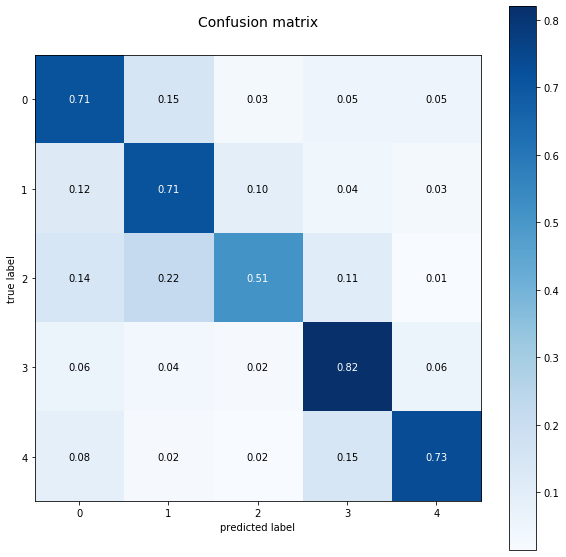

In [1684]:
from sklearn.ensemble import GradientBoostingClassifier
final_model = SVC(C = 3.5, kernel = 'linear', gamma='auto', random_state=42, class_weight={0:2,2:3})
 

# Fit 2nd level model
final_model = final_model.fit(S_train, y_train_os)

# Predict
y_pred = final_model.predict(S_test)

print("\nClassifier results: \n")
print(classification_report(y_test, y_pred, target_names = list(encoder.classes_)))

# CREATING THE CONFUSION MATRIX
fig, ax = plot_confusion_matrix(conf_mat = confusion_matrix(y_test, y_pred),
                                colorbar = True,
                                show_absolute = False,
                                show_normed = True,
                                figsize = (10,10))
plt.title("Confusion matrix", fontsize=14)
plt.show()

## Testing / prediction

In [1501]:
text = "cancer"
testing = np.array(get_emb(text))
testing = testing.reshape(1, -1)
testing = stack.transform(testing)
final_model.predict(testing)

Transforming...

estimator  0: [rf: RandomForestClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  1: [svc: SVC]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  2: [mlp: MLPClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  3: [lgbm: LGBMClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  4: [lr: LogisticRegression]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE



array([1])

In [839]:
inference_data = pd.read_csv("inference_data.csv")
inference_data.tail(2)

,hashtags,processed_text,text,timestamp,tweet_id,user_location,username
7946,NaN,god motherfucker dick in your sister s ass,God motherfucker dick in your sister's ass,2020-05-20 12:02:30+00:00,1.263078e+18,NaN,Anshulthegr8
7947,NaN,dont worry laurej by the way why your father b...,"Dont worry laurej, by the way why your father ...",2020-05-22 15:02:41+00:00,1.263848e+18,NaN,DesiMogambo


In [840]:
inference_data.dropna(axis=0,subset=['text','timestamp'],inplace=True)
inference_data.isnull().sum()

hashtags          4912
processed_text       0
text                 0
timestamp            0
tweet_id             0
user_location      759
username             0
dtype: int64

In [842]:
inference_data.drop_duplicates(subset=['tweet_id'], keep="first",inplace=True)
inference_data.reset_index(drop=True, inplace=True)
inference_data.shape

(7948, 7)

In [843]:
clean_text(inference_data,'text')

inference_data = inference_data[inference_data.processed_text !='']
inference_data.shape

Cleaning text and adding column 'processed_text'
DONE! 



(7948, 7)

In [938]:
data_test = []
for sentence in (inference_data.processed_text.values):
    data_test.append(get_emb(sentence))

data_test = np.array(data_test)

In [939]:
data_test = stack.transform(data_test)
y_pred = final_model.predict(data_test)

Transforming...

estimator  0: [clf1: RandomForestClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  1: [clf2: XGBClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  2: [clf3: SVC]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  3: [clf4: MLPClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  4: [clf5: LGBMClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  5: [clf6: LogisticRegression]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done


In [940]:
inference_data['label'] = list(y_pred)

for i,row in inference_data.iterrows():
    inference_data.label[i] = list(encoder.classes_)[row.label]

C:\Users\welcome\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\welcome\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [1279]:
inference_data.label.value_counts()

NON_D_VIOLENCE_ABOUT    3763
DV_OPINION              2148
NO_VIOLENCE              802
DV_OPINION_INFO_NEWS     675
DV_INCIDENT              560
Name: label, dtype: int64

In [1400]:
#SKIM THROUGH DATASet 

for i,row in inference_data.iterrows():
    if row.label=='DV_OPINION':
        print(row.text,'\n-----')

Super movement sandhya. Domestic violence needs to be crushed at d root.Alcohol,circumstances &amp; stress r just excuses. Root of d problem is upbringing.if a man hits his wife once, dont excuse him, coz he is gonna hit again fot sure. #DomesticViolence 
-----
”Being a woman's father does not give you the right to force her into any marriage and being her husband does not give you the right to abuse or disrespect her.” Have a blessed and stress free fun filled Thursday - stay indoor stay safe 
-----
Wouldn’t alcohol abuse increase domestic violence and child abuse at this point in time. 
-----
These are solvable and @MSF_ChalkLit can help. What we need to be worried about it . Future mental health and anxiety issues . Child abuse . Domestic violence with Children Who can we reach out to help on eveyything 
-----
Shocked to learn the number of calls received by child line on child abuse during the  days of lockdown. Help these children. Raise voice against child abuse. 
-----
Everytime

Milani Salpitikorala- saving children’s lives from state and domestic abuse 
-----
@MinistryWCD A victim of #domesticabuse from very poor background is admitted in Distt. Hospital Rajouri for many days, she's prescribed CT Scan. She called #OneStopCenter Rajouri but CA says there's no such budget for victims.Can @dcrajouri pl help? Dswo has the details. 
-----
.@Aangan_Trust, #Communications highlight lockdown domestic abuse. #SumantoChattopadhyay #RatnaGill @Shikhajourno 
-----
I am her voice today and the voices of the many victims of domestic abuse which are going unheard as they are locked up with their abusers #lockdownmeinlockup. Rising number of cases have… https://www.instagram.com/p/CAMWHypKzdZleRuOmhPihYscyVPZMsoKs/?igshid=ohuunjewf 
-----
Speak up before it is too late. #LockdownmeinLockup. #standupforyourself #womenempowerment #HelplineNumbers : Domestic Abuse:  Women's Helpline:  Police Helpline: 
-----
Do you know of anyone who has reported domestic abuse since the corona

Govt to focus on ) Mental & Phyical health. #Corona will lead to increased Obesity, Depression, Drug Addiction, Alcoholism, Domestic Violence, Anxiety, Heart diseases Junk Food consumption. Encourage walking, Invest in high quality broadband @narendramodi 
-----
With help from a new app, Czech delivery staff and postal workers are now being trained to search for signs of domestic violence during quarantine  
-----
#arrestakhileshwaranda for abusing a married women.The Protection of Women from Domestic Violence Act  different from the provision of the Penal Code - section A of the Indian Penal Code - in that it provides a broader definition of domestic violence. 
-----
It's diplomatically incorrect but people resort to media trials because the Justice system of India does not work! After trying to help #DomesticViolence survivors for over a decade, nothing has changed, the system only works if you know the @CPDelhi, otherwise @DelhiPolice 
-----
Say know to Domestic violence..whatsapp @

-----
Still rapes are happening, domestic violence has been doubled. Is this you were talking about??? 
-----
How ironic! The government has opened take away alcohol shops but shuts down Santhwana centres. Giving the bottle to the man while shutting down the care centres for victims of domestic violence. So very thoughtful! / 
-----
Any idea what number men suffering from domestic violence need to dial on? 
-----
#DomesticViolence is a threat amid #COVID &amp; #Lockdown woes Legal expert @ramariyer explains what one should do if faced with this 
-----
@seanhannity @TuckerCarlson Pelosi has &gt;$ million in her nightmare hero bill for domestic violence How will that possibly stop violence of any kind except the violence of raping the tax payers 
-----
Thank you @DeogharPolice for timely intrevention and action. Domestic violence and humiliation has definitely reduced. Hope status quo remains for long term. Appreciate it. Heartfelt thanks from a daughter for helping her parents. 
-----
H

Yeah! You should look why that’s happening. It is a shit App! Promoting Violence against Women, No policy to find out shitty content of promoting Rape, Domestic Violence and Acid Attacks!!! 
-----
Yes i'm a survivor. Domestic violence, child abuse, mentally, verbally, even physically (yes, physically too.) 
-----
Selangor Journal | MCO sees spike in domestic violence cases https://selangorjournal.my///mco-sees-spike-in-domestic-violence-cases/?utm_source=dlvr.it&amp;utm_medium=twitter 
-----
Spike in domestic violence cases during MCO 
-----
Tsai talks about fixing holes in the social safety net, and specifically mentions devoting greater resources to mental health issues and domestic violence. 
-----
Saya ada kwn yg physiology advisor dgn Kementerian Kesihatan. Dia ckp setiap hari tak henti aduan ttg 'domestic violence' ni masuk sepanjang tempoh PKP, PKPB.  
-----
In garb of entertainment, TikTok promotes rape, domestic violence. #tiktokbanindia #tiktokexposed @NCWIndia @PMOIndia @ras

More than , #SOS calls were made to The #Childline #India #helpline by people asking help for protection from verbal and #sexualabuse and #violence at home. #COVIDindia #lockdown #Narendermodi #section Read the article to know more - https://thedailyreport.in/domestic-violence-escalatesthe-lockdown-effect/ 
-----
Dr. Ashwini rightly pointed out the lockdown throws unique challenges to reporting cases of child sexual abuse. We need to encourage the child to call a trusted relative and report abuse or better still the child can report the incident directly with the Child Helpline - . 
-----
U know that emotional abuse is even worse!! No matter how bad he did ,he’s still a “child “!Send him to his room until u calm down than explain to him his mistakes,I can’t believe how many people say “ it’s ok “ to shout on a child like this !! Stop abusing ur kids ! #نهى_نبيل 
-----
Feminists : We need laws against emotional abuse of women by men. Also Le Feminists : It's a woman's choice if she chea

In [1438]:
inference_data.to_csv("combined_with_labels.csv", index=False)